# Import modules

In [1]:
import numpy as np
import cirq as cirq
import matplotlib.pyplot as plt                    

# Mathematical functions

In [2]:
def f_aux(a):     
    c = 0
    if a == 1:
            c = 1
    elif a == 2:
            c = -1
    return c

def g_aux(a, l, n):
    c = 0
    if l != 0 and l != 2**n -1:
        if a == l+1:
            c = 1
        elif a == l-1:
            c =2
    elif l == 0:
        if a == l+1:
            c = 1
    elif l == 2**n -1:
        if a == l-1:
            c = 1
    return c


def sins(angle, x, n):    
    c = 0 
    if abs(angle*2**n-x) < 0.0001:
        c = 2**n
    else:
        c = (1-np.exp(complex(0, 2*np.pi* (2**n*angle-x))))/(1-np.exp(complex(0,2*np.pi*(angle-x/(2**n)))))
    return c

# Task functions 

In [180]:
def random_unitary(D):             #Generates a random unitary. Outputs the normalized angles correspon-                                                         
                                  #ding to its eigenvalues and the projections of a generated random state 
                                  #towards the eigenvectors of that unitary.
            U = cirq.testing.random_unitary(D)     #Random Haar unitary        
            eigenvas = np.linalg.eig(U)[0] 
            angles = np.zeros(D)
            for i in range(D):
                signsin = 0
                if np.imag(eigenvas[i]) < 0:
                    signsin = 1
                aux = int((np.arctan(np.imag(eigenvas[i])/np.real(eigenvas[i]))+ signsin*np.pi)/(2*np.pi))
                if aux > 0:
                    angles[i] = np.arctan(np.imag(eigenvas[i])/np.real(eigenvas[i]))+ signsin*np.pi - 2*np.pi*aux
                elif aux<0:
                    angles[i] = 2*np.pi + np.arctan(np.imag(eigenvas[i])/np.real(eigenvas[i]))+ signsin*np.pi - 2*np.pi*aux
                elif aux == 0:
                    if np.arctan(np.imag(eigenvas[i])/np.real(eigenvas[i]))+ signsin*np.pi >= 0:
                        angles[i] = np.arctan(np.imag(eigenvas[i])/np.real(eigenvas[i]))+ signsin*np.pi
                    else:
                        angles[i] = 2*np.pi + np.arctan(np.imag(eigenvas[i])/np.real(eigenvas[i]))+ signsin*np.pi
                    
                
            angles /= (2*np.pi)                     #Conveniently normalized angles
            
            
            
            eigenves = np.linalg.eig(U)[1] 
            superposition_state = np.zeros(D, dtype = complex)       #Equally weighted superposition state (U-eigenbasis referred)
            for i in range(D):
                suma = 0
                for k in range(D):
                    suma += eigenves[i][k]
                superposition_state[i] = 1/np.sqrt(D)*suma
            M = np.zeros((D, 2**n), dtype = complex)               #Seed state generator Matrix
            for i in range(D):
                for j in range(2**n):
                    M[i][j] = sins(angles[i], j, n)
            norm = 0
            for i in range(D):
                for j in range(2**n):
                    norm += abs(M[i][j])**2
            
            
            for i in range(D):
                for j in range(2**n):
                    M[i][j] = M[i][j]/np.sqrt(norm)
            probs = np.zeros(2**n)                                 #Marginal probability distribution 
            for i in range(2**n):
                suma = 0
                for k in range(D):
                    suma += abs(M[k][i])**2
                probs[i] = suma

            seed = np.random.choice(2**n, 1, p=probs)

            seed_state = np.zeros(D, dtype = complex)           #Seed state
            norms = []
            for i in range(D):
                seed_state[i] = M[i][seed]
                norms.append(abs(seed_state[i])**2)
            norm = np.sum(norms)
            for i in range(D):
                seed_state[i] = seed_state[i]/np.sqrt(norm)
            V = np.zeros((D, D), dtype = complex)                #Unitary transformation diagonalizing U                                                  
            for i in range(D):
                for j in range(D):
                    suma = 0
                    for k in range(D):
                        if k == j:
                            suma += eigenves[i][k]
                    V[i][j] = suma
            random_state = np.zeros(D, dtype = complex)        #Random initial state
            for i in range(D):
                suma = 0
                for k in range(D):
                    suma += V[i][k]*seed_state[k]
                random_state[i] = suma

            proj = np.zeros(D, dtype = complex)               #Projection to each eigenstate of U
            for i in range(D):
                suma = 0
                for k in range(D):
                    suma += np.conj(eigenves[k][i])*random_state[k]  
                proj[i] = suma
        
            return [angles, proj]

def certifier_test(angles, proj, n, D):
            
            probs = np.zeros(2**n)   #Probability associated to each different qPUF outcome when queried by the certifier
         
            for i in range(2**n):
                suma = 0
                for k in range(D):
                        suma += abs(proj[k]*sins(angles[k], i , n))**2
                probs[i] = suma
            
            norm = np.sum(probs)
            
            probs /= norm
            
            l = np.random.choice(2**n, 1, p = probs)  #Outcome obtained by the certifier
            
            phi_1 = np.zeros(D, dtype = complex)  #Pure state after certifier's query. The outcome is reported
            norm = 0
            for i in range(D):
                    phi_1[i] = proj[i]*sins(angles[i], l, n)
                    norm += abs(phi_1[i])**2
            phi_1 /= np.sqrt(norm)         #Normalization is needed after measurement
            
            rho_1 = np.outer(phi_1, np.conj(phi_1))  #phi_1 written in mixed states formalism
            return [l, rho_1, phi_1]

def possible_outcomes(previous, l, n):       #Given the list of possible outcomes reached after previous queries, it returns
                auxiliar = 3
                if l == 0 or l == 2**n -1:
                    auxiliar = 2                             #an updated list after one more query is performed.
                outcomes = []
                number_states = 0    #Number of different attainable states after "t" queries. i.e. number of different attainable sequences of user's outcomes.
                for x in previous:
                            if l != 0 and l != 2**n -1:
                                number_states += auxiliar
                                for k in range(auxiliar):                                     
                                    update = []                                   
                                    for h in x:
                                        update.append(h)
                                    update.append(l + f_aux(k))
                                    outcomes.append(update)
                            elif l == 0:
                                number_states += auxiliar
                                for k in range(auxiliar):         
                                    update = []                                   
                                    for h in x:
                                        update.append(h)
                                    update.append(k)
                                    outcomes.append(update)
                            elif l == 2**n -1:
                                number_states += auxiliar
                                for k in range(auxiliar):
                                    update = []                                   
                                    for h in x:
                                        update.append(h)
                                    update.append(l-k)
                                    outcomes.append(update)
                return outcomes

def possible_outcomes_strict(previous, l, n, t):       #Given the list of possible outcomes reached after previous queries, it returns
                update = np.zeros(t+2)                                   
                for i in range(t+1):
                    update[i] = previous[0][i]
                update[t+1] = l
                return [update]
            
            
            
def possible_states_t(outcomes, angles, proj, l, n, D):
                number_states = len(outcomes)
                states_t = np.zeros((number_states, D), dtype = complex) #Different attainable states after "t" queries corresponding to each different attainable outcomes sequence.
                auxiliar = 3
                if l == 0 or l == 2**n -1:
                    auxiliar = 2
                norms = np.zeros(number_states)
                counts = 0
                for y in range(int(number_states/auxiliar)):
                    for j in range(D):
                        prod = proj[j]
                        for s in range(t+1):
                            prod *= sins(angles[j], outcomes[counts][s], n)
                        for k in range(auxiliar):
                            prod_aux = np.copy(prod)
                            if l != 0 and l!= 2**n-1:
                                prod_aux *= sins(angles[j], l + f_aux(k), n)
                            elif l == 0:
                                prod_aux *= sins(angles[j], l + k, n)
                            elif l == 2**n-1:
                                prod_aux *= sins(angles[j], l - k, n)
                            norms[y*auxiliar + k ] += abs(prod_aux)**2
                            states_t[y*auxiliar+k][j] = prod_aux
                    counts += auxiliar
                
                for y in range(number_states):
                            states_t[y] /= np.sqrt(norms[y])
                locs = []
                for i in range(D):
                    if abs(states_t[0][i])**2 > 0.2:
                        locs.append(i)
                    
                
                return states_t
            
def probs_t(outcomes,angles, proj, l, n, D, t):
                auxiliar = 3
                if l == 0 or l == 2**n -1:
                    auxiliar = 2
                number_states = len(outcomes)
                probs_t = np.ones(number_states)        #Probability of reaching each possible state after "t" queries    
                counts = 0
                for y in range(int(number_states/auxiliar)):          
                        probs_yt = np.zeros((auxiliar, t+1))        #List of probabilities of getting each outcome conditioned to previous ones
                        for s in range(t+1):
                                probs_aux = np.zeros(auxiliar)
                                for k in range(auxiliar):
                                    for j in range(D):
                                        prod = proj[j]
                                        for u in range(s+2):
                                            if u == s+1:    
                                                if l != 0 and l != 2**n - 1:
                                                        prod *= sins(angles[j], l + f_aux(k), n)
                                                elif l == 0:
                                                        prod *= sins(angles[j], l+k, n)
                                                elif l == 2**n -1:
                                                        prod *= sins(angles[j], l-k, n)
                                            else:
                                                    prod *= sins(angles[j], outcomes[counts][u], n)
                                        probs_aux[k] += abs(prod)**2
                                for k in range(auxiliar):
                                    if s < t:
                                        probs_yt[k][s] = probs_aux[g_aux(outcomes[counts][s+1],l, n)]/np.sum(probs_aux)
                                    elif s == t:
                                        probs_yt[k][s] = probs_aux[k]/np.sum(probs_aux)
                        for k in range(auxiliar):
                            for x in probs_yt[k]:
                                probs_t[y*auxiliar+k] *= x
                        counts += auxiliar
                
                probs_t /= np.sum(probs_t)
                
                return probs_t

def build_mixed(p, phis, D):
    rho = np.zeros((D, D), dtype = complex)
    for k in range(len(p)):
        rho += p[k]*np.outer(phis[k], np.conj(phis[k]))
        
    return rho

def quantities(phi_1, angles, proj, n, p):
                deviations = 0
                lista = [] #List containing all strong amplitudes
                compos = [] #List containing all strong components' positions.
                minimum = 10
                location = []
                for i in range(D):
                    if abs(2**n *angles[i]-l) < 1 or abs(2**n *angles[i]-l)> 15 : 
                        if min([abs(2**n *angles[i]-l), abs(2**n *angles[i]-l) -16]) < minimum:
                            minimum = min([abs(2**n *angles[i]-l), abs(2**n *angles[i]-l) -16])
                            location = i
                        if abs(phi_1[i])**2 > 0.05:  #Takes care of the fact that some strong components "i" are actually weak because being multiplied by tiny proj[i]
                                lista.append(abs(phi_1[i])**2)
                                compos.append(i)
                
                number_strong= len(compos)          
                
                differences= 1-np.sum(lista)
                
                if number_strong == 1:
                    if compos[0] != location:
                        number_strong = 10
                    components = abs(phi_1[location])**2
                    differences = 1 - components
                
                elif number_strong >1 and number_strong < 10:
                    avge = 0
                    for u in lista:
                        avge += u/number_strong
                    var = 0
                    for u in lista:
                        var += abs(u-avge)**2/number_strong
                    deviations = np.sqrt(var)
                
                
                return [number_strong, differences, deviations]

def all_outcomes(previous, n, t):       
        outcomes = []
        for x in previous:
                for k in range(2**n):                                     
                        update = np.zeros(t+2)                                   
                        for i in range(t+1):
                            update[i] = x[i]
                        update[t+1] = k
                        outcomes.append(update)   
        return outcomes

    
def probs_t_all(number_sequences, angles, proj, all_outcomes, l, n, D, t):                
                p_t_all = np.ones(number_sequences) #Probability of reaching each possible outcomes sequence after "t" queries
                auxiliar = 3
                if l == 0 or l == 2**n -1:
                    auxiliar = 2
                counts = 0
                for y in range(int(number_sequences/(2**n))):          
                        probs_yt = np.zeros((2**n, t+1))        #List of probabilities of getting each outcome conditioned to previous ones
                        for s in range(t+1):
                                if s < t:
                                    probs_aux = np.zeros(auxiliar)
                                    for k in range(auxiliar):
                                        for j in range(D):
                                            prod = proj[j]
                                            for u in range(s+2):
                                                if u == s+1:    
                                                    if l != 0 and l != 2**n -1:
                                                        prod *= sins(angles[j], l + f_aux(k), n)
                                                    elif l == 0:
                                                        prod *= sins(angles[j], l + k, n)
                                                    elif l == 2**n-1:
                                                        prod *= sins(angles[j], l - k, n)
                                                else:      
                                                    prod *= sins(angles[j], all_outcomes[counts][u], n)
                                            probs_aux[k] += abs(prod)**2
                                    for k in range(2**n):
                                            probs_yt[k][s] = probs_aux[g_aux(all_outcomes[counts][s+1],l, n)]/np.sum(probs_aux)
                                elif s == t:
                                    probs_aux = np.zeros(2**n)
                                    for k in range(2**n):
                                        for j in range(D):
                                            prod = proj[j]
                                            for u in range(s+2):
                                                if u == s+1:    
                                                        prod *= sins(angles[j], k, n)
                                                else:    
                                                        prod *= sins(angles[j], all_outcomes[counts][u], n)
                                            probs_aux[k] += abs(prod)**2
                                    for k in range(2**n):
                                        probs_yt[k][s] = probs_aux[k]/np.sum(probs_aux)
                        for k in range(2**n):
                            for x in probs_yt[k]:
                                p_t_all[counts+k] *= x
                        counts += 2**n
                
                
                p_t_all /= np.sum(p_t_all)
                return p_t_all 

def probs_t_all_strict(number_sequences, angles, proj, all_outcomes, l, n, D, t):                
                p_t_all = np.ones(number_sequences) #Probability of reaching each possible outcomes sequence after "t" queries
                auxiliar = 1
                counts = 0
                for y in range(int(number_sequences/(2**n))):          
                        probs_yt = np.zeros((2**n, t+1))        #List of probabilities of getting each outcome conditioned to previous ones
                        for s in range(t+1):
                                if s < t:
                                    probs_aux = np.zeros(auxiliar)
                                    for k in range(auxiliar):
                                        for j in range(D):
                                            prod = proj[j]
                                            for u in range(s+2):
                                                if u == s+1:    
                                                    if l != 0 and l != 2**n -1:
                                                        prod *= sins(angles[j], l + f_aux(k), n)
                                                    elif l == 0:
                                                        prod *= sins(angles[j], l + k, n)
                                                    elif l == 2**n-1:
                                                        prod *= sins(angles[j], l - k, n)
                                                else:      
                                                    prod *= sins(angles[j], all_outcomes[counts][u], n)
                                            probs_aux[k] += abs(prod)**2
                                    for k in range(2**n):
                                            probs_yt[k][s] = probs_aux[g_aux(all_outcomes[counts][s+1],l, n)]/np.sum(probs_aux)
                                elif s == t:
                                    probs_aux = np.zeros(2**n)
                                    for k in range(2**n):
                                        for j in range(D):
                                            prod = proj[j]
                                            for u in range(s+2):
                                                if u == s+1:    
                                                        prod *= sins(angles[j], k, n)
                                                else:    
                                                        prod *= sins(angles[j], all_outcomes[counts][u], n)
                                            probs_aux[k] += abs(prod)**2
                                    for k in range(2**n):
                                        probs_yt[k][s] = probs_aux[k]/np.sum(probs_aux)
                        for k in range(2**n):
                            for x in probs_yt[k]:
                                p_t_all[counts+k] *= x
                        counts += 2**n
                
                
                p_t_all /= np.sum(p_t_all)
                return p_t_all   
            
def probs_t_all_test_strict(number_sequences, angles, proj, all_outcomes, l, n, D, t):                
                probs = np.zeros(2**n) #Probability of reaching each possible outcomes sequence after "t" queries
                for y in range(int(number_sequences/(2**n))):          
                    for k in range(2**n):
                            suma = 0        
                            for j in range(D):
                                suma += abs(proj[j]*sins(angles[j], l , n)**(t+1)*sins(angles[j], k , n))**2
                            probs[k] = suma               
                probs /= np.sum(probs)
                return probs             

def probs_t_all_test_relaxed(number_sequences, angles, proj, all_outcomes, l, n, D, t, minus, plus, exact, selection):                
                probs = np.zeros(2**n) #Probability of reaching each possible outcomes sequence after "t" queries
                for y in range(int(number_sequences/(2**n))):          
                    for k in range(2**n):
                            suma = 0        
                            for j in range(D):
                                suma += abs(proj[j]*sins(angles[j], l , n)**(1+selection+exact)*sins(angles[j], l-1 , n)**minus*sins(angles[j], l+1 , n)**plus*sins(angles[j], k , n))**2
                            probs[k] = suma               
                probs /= np.sum(probs)
                return probs  
                                            
                                            
                                            
def p_acceptance(number_sequences, l, all_outcomes, p_t_all):            
    c = 0        
    for y in range(number_sequences):
                    if l == 0:
                            if all_outcomes[y][-1] == l or all_outcomes[y][-1]== l+1:
                                c += p_t_all[y]
                    elif l == 2**n-1:
                            if all_outcomes[y][-1] == l or all_outcomes[y][-1]== l-1:
                                c += p_t_all[y]
                    elif l != 0 and l != 2**n-1:
                            if all_outcomes[y][-1] == l or all_outcomes[y][-1]== l+1 or all_outcomes[y][-1]== l-1:
                                c += p_t_all[y]
    return c

def p_acceptance_strict(number_sequences, l, all_outcomes, p_t_all):            
    c = 0        
    for y in range(number_sequences):
                if all_outcomes[y][-1] == l:
                    c += p_t_all[y]
                    
    return c

def more_quantities(l,angles, proj, n):
                diff = [10]
                compos = []
                for i in range(D):
                    if abs(2**n * angles[i] -l) < diff[-1]:
                        diff.append(abs(2**n * angles[i] -l))
                        compos.append(i)
                int_approx = diff[-1]
                main_proj = 1-abs(proj[compos[-1]])**2
                return [int_approx, main_proj]

# Main variables 

In [186]:
D = 16 #Dimension of the eigenvectors of the unitary
n = 4 #Number of ancillary qubits
T = 300  #Number of user's queries                   
Y = 1000   #Number of different users 

# Investigation of fidelity between  user's system and  |phi'><phi'| .

In [6]:
Fidelities = []          #List of lists. Each list contains set of fidelities after T user's iteriations. For different users.
for p in range(Y):
            experiment = random_unitary(D)                 #Certifier running the qPUF
        
            angles =  experiment[0]                        #Normalized angles from the random Unitary's eigenvalues.
            
            proj = experiment[1]            #Projections of the randomly generated state towards Unitary's eigenvectors.
            
            test  = certifier_test(angles, proj, n, D)     #Outcome obtained by the certifier
            
            l = test[0]
            
            rho_1 = test[1]  #Pure state delivered to the user 
            
            outcomes = [[l]]         # (1+ k)-th component owns the list of all possible outcomes that are attainable after k-th user's query. Being all queries succesful in the verification protocols.
            
            fidelities = []          #List of fidelities towards rho_1
            for t in range(T):
                outcomes = possible_outcomes(outcomes, l, n)  #List of possible outcomes' sequences after t+1 verification protocols.
                states_t = possible_states_t(outcomes, angles, proj, l, n, D) #Different attainable states after "t" queries corresponding to each different attainable outcomes sequence.
                p_t = probs_t(outcomes,angles, proj, l, n, D, t)       #Probability of reaching each possible state after "t" queries
                rho_t = build_mixed(p_t, states_t, D)
                fidelities.append(cirq.fidelity(rho_t, rho_1, D))  
            Fidelities.append(fidelities)


# Plotting fidelities

Text(0, 0.5, 'Fidelity')

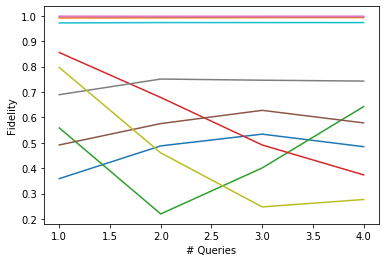

In [907]:
x = np.zeros(T)
for i in range(T):
    x[i] = i+1
for y in range(Y):
    plt.plot(x, Fidelities[y])
plt.xlabel('# Queries')
plt.ylabel('Fidelity')


# Finding correlations between the first fidelity and 3 quantities of interest

In [7]:
#These 4 quantities, when propely ploted, will shed some light on why some times fidelity agains first system given to the user drops.

fidelities = []    #List containing fidelity towards first system given to the user for Y different users.             
number_strong = [] #"Number of strong components"  List containing the number of different "angles" for which angle*2**n-l is small enough, <1 or >15
differences = []   #1 - sum of amplitudes involving strong amplitudes
deviations = []    #If number of strong components > 1. It contains the standard deviation between different strong amplitudes.

for p in range(Y):
            experiment = random_unitary(D)    #Certifier running the qPUF
            
            angles =  experiment[0]           #Normalized angles from the random Unitary's eigenvalues.
            
            proj = experiment[1]              #Projections of the randomly generated state towards Unitary's eigenvectors.
            
            test = certifier_test(angles, proj, n, D) #Outcome obtained by the certifier
            
            l = test[0]
            rho_1 = test[1]  #Pure state delivered to the user (matrix)
            
            phi_1= test[2]   #Pure state delivered to the user (ket)
            
            outcomes = [[l]]         # (1+ k)-th component owns the list of all possible outcomes that are attainable after k-th user's query. Being all queries succesful in the verification protocol.
            
            for t in range(T):
                outcomes = possible_outcomes(outcomes, l, n)  #List of possible outcomes' sequences after t+1 verification protocols.
                states_t = possible_states_t(outcomes, angles, proj, l, n, D) #Different attainable states after "t" queries corresponding to each different attainable outcomes sequence.
                p_t = probs_t(outcomes,angles, proj, l, n, D, t)       #Probability of reaching each possible state after "t" queries
                rho_t = build_mixed(p_t, states_t, D)
                fidelities.append(cirq.fidelity(rho_t, rho_1, D))  
                number_strong.append(quantities(phi_1, angles,proj, n, p)[0])  #We here compute the quantities of interest for the study we are doing.
                differences.append(quantities(phi_1, angles,proj, n, p)[1])
                deviations.append(quantities(phi_1, angles,proj, n, p)[2])
                

# Plotting Correlations

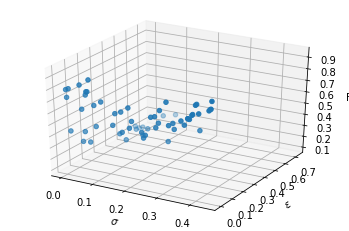

Text(0, 0.5, 'F')

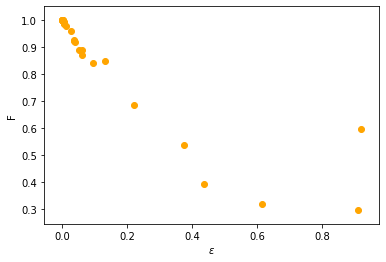

In [863]:

x = number_strong
y = differences
z = fidelities
j = []

for u in range(Y):
    if x[u] > 1 and x[u]< 10:
        j.append(deviations[u])
h = []
t = []
for u in range(Y):
    if x[u] > 1 and x[u] <10:
        h.append(fidelities[u])
        t.append(differences[u])



fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(j, t, h)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\epsilon$')
ax.set_zlabel('F')



plt.show()
new_y = []
new_z = []
for u in range(Y):
    if x[u] == 1:
        new_y.append(y[u])
        new_z.append(z[u])
plt.scatter(new_y, new_z, color = 'orange')

plt.xlabel(r'$\epsilon$')
plt.ylabel('F')

# Investigation: Does the system converge to some state?

In [25]:
Fidelities = []          #List of lists. Each list contains set of fidelities after T user's iteriations. For different users.
for p in range(Y):
            experiment = random_unitary(D)                 #Certifier running the qPUF
        
            angles =  experiment[0]                        #Normalized angles from the random Unitary's eigenvalues.
            
            proj = experiment[1]            #Projections of the randomly generated state towards Unitary's eigenvectors.
            
            test  = certifier_test(angles, proj, n, D)     #Outcome obtained by the certifier
            
            l = test[0]
            
            rho_1 = test[1]  #Pure state delivered to the user 
            rhos = []
            rhos.append(rho_1)
            
            outcomes = [[l]]         # (1+ k)-th component owns the list of all possible outcomes that are attainable after k-th user's query. Being all queries succesful in the verification protocols.

            fidelities = []          #List of fidelities towards rho_1
            for t in range(T):
                outcomes = possible_outcomes(outcomes, l, n)  #List of possible outcomes' sequences after t+1 verification protocols.
                states_t = possible_states_t(outcomes, angles, proj, l, n, D) #Different attainable states after "t" queries corresponding to each different attainable outcomes sequence.
                p_t = probs_t(outcomes,angles, proj, l, n, D, t)       #Probability of reaching each possible state after "t" queries
                rho_t = build_mixed(p_t, states_t, D)
                fidelities.append(cirq.fidelity(rho_t, rhos[-1], D))  
                rhos.append(rho_t)
            Fidelities.append(fidelities)

# Plotting fidelities

Text(0, 0.5, 'Fidelity')

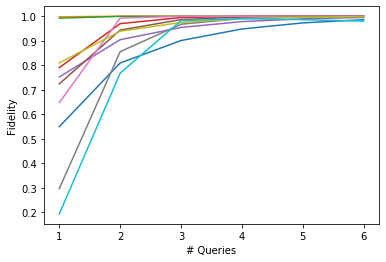

In [18]:
x = np.zeros(T)
for i in range(T):
    x[i] = i+1
for y in range(Y):
    plt.plot(x, Fidelities[y])
plt.xlabel('# Queries')
plt.ylabel('Fidelity')


# New signature: Probability of acceptance. Iterative scheme

In [912]:
Probs_a = []          #List of lists of acceptance probabilities for different users.
for p in range(Y):
            experiment = random_unitary(D)    #Certifier running the qPUF            
            angles =  experiment[0]           #Normalized angles from the random Unitary's eigenvalues.            
            proj = experiment[1]              #Projections of the randomly generated state towards Unitary's eigenvectors.            
            test = certifier_test(angles, proj, n, D) #Outcome obtained by the certifier            
            l = test[0]                       
            outcomes = [[l]]     # (1+ k)-th component owns the list of all possible outcomes that are attainable after k-th user's query. Being all queries succesful in the verification protocol.
            p_a = np.zeros(T)    #List of expected probabilities of acctepance in an iterative scheme.
            for t in range(T):
                number_sequences = len(all_outcomes(outcomes, n, t))
                p_t_all = probs_t_all(number_sequences, angles, proj, all_outcomes(outcomes, n, t), l, n, D, t)
                p_a[t] = p_acceptance(number_sequences, l, all_outcomes(outcomes, n, t), p_t_all)
                outcomes = possible_outcomes(outcomes, l, n)
            Probs_a.append(p_a)
                

# Plotting probability of acceptance vs # of queries

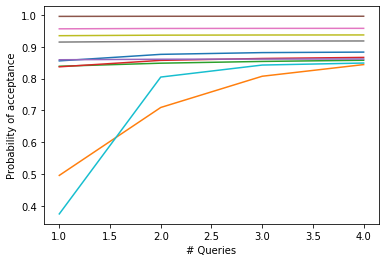

In [913]:
x = np.zeros(T)
for i in range(T):
    x[i] = i+1
for y in Probs_a:
    plt.plot(x, y)
plt.xlabel('# Queries')
plt.ylabel('Probability of acceptance')
plt.show()

# T-th probability of acceptance (convergent one) vs quantities of interest 

In [173]:
Probs_a = []          #List of T-th acceptance probabilities for different users.
int_approx = []
main_proj = []
for p in range(Y):
            experiment = random_unitary(D)    #Certifier running the qPUF            
            angles =  experiment[0]           #Normalized angles from the random Unitary's eigenvalues.            
            proj = experiment[1]              #Projections of the randomly generated state towards Unitary's eigenvectors.            
            test = certifier_test(angles, proj, n, D) #Outcome obtained by the certifier            
            l = test[0]                       
            outcomes = [[l]]     # (1+ k)-th component owns the list of all possible outcomes that are attainable after k-th user's query. Being all queries succesful in the verification protocol.
            p_a = 0    #List of expected probabilities of acctepance in an iterative scheme.
            for t in range(T):
                number_sequences = len(all_outcomes(outcomes, n, t))
                p_t_all = probs_t_all(number_sequences, angles, proj, all_outcomes(outcomes, n, t), l, n, D, t)
                if t == T-1:
                    p_a = p_acceptance(number_sequences, l, all_outcomes(outcomes, n, t), p_t_all)
                outcomes = possible_outcomes(outcomes, l, n)
            Probs_a.append(p_a)
            int_approx.append(more_quantities(l,angles, proj, n)[0])
            main_proj.append(more_quantities(l,angles, proj, n)[1])



KeyboardInterrupt: 

# Plotting T-th probability of acceptance (convergent one) vs quantities of interest

Text(0.5, 0, 'P_')

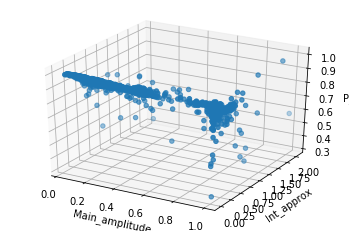

In [923]:
x = main_proj
y = int_approx
z = Probs_a
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
plt.xlabel('Main_amplitude_')
plt.ylabel('Int_approx')
ax.set_zlabel('P_')

# Selecting proper initial states and checking them

# Initial stage: Strict iterative scheme to discard bad states.

In [107]:
Probs_a = []          #List of lists of acceptance probabilities for different users.
for p in range(Y):
            print(p)
            experiment = random_unitary(D)    #Certifier running the qPUF            
            angles =  experiment[0]           #Normalized angles from the random Unitary's eigenvalues.            
            proj = experiment[1]              #Projections of the randomly generated state towards Unitary's eigenvectors.            
            test = certifier_test(angles, proj, n, D) #Outcome obtained by the certifier            
            l = test[0]                       
            outcomes = [[l]]     # (1+ k)-th component owns the list of all possible outcomes that are attainable after k-th user's query. Being all queries succesful in the verification protocol.
            p_a = np.zeros(T)    #List of expected probabilities of acctepance in an iterative scheme.
            for t in range(T):
                number_sequences = len(all_outcomes(outcomes, n, t))
                p_t_all = probs_t_all_strict(number_sequences, angles, proj, all_outcomes(outcomes, n, t), l, n, D, t)
                p_a[t] = p_acceptance_strict(number_sequences, l, all_outcomes(outcomes, n, t), p_t_all)
                outcomes = possible_outcomes_strict(outcomes, l, n, t)
            Probs_a.append(p_a)
                

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# Plotting probabbility of strict acceptance vs number of queries

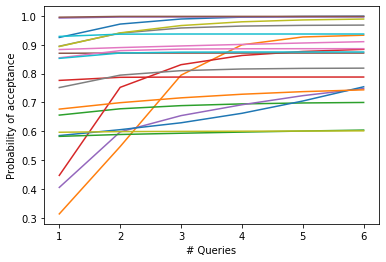

In [108]:
x = np.zeros(T)
for i in range(T):
    x[i] = i+1
for y in Probs_a:
    plt.plot(x, y)
plt.xlabel('# Queries')
plt.ylabel('Probability of acceptance')
plt.show()

# Testing a strict + relaxed (or strict) phases scheme

In [187]:
N_tests = []
eff = 0
for p in range(Y):
            print(p)
            experiment = random_unitary(D)    #Certifier running the qPUF            
            angles =  experiment[0]           #Normalized angles from the random Unitary's eigenvalues.            
            proj = experiment[1]              #Projections of the randomly generated state towards Unitary's eigenvectors.            
            test = certifier_test(angles, proj, n, D) #Outcome obtained by the certifier            
            l = test[0]                       
            outcomes = [[l]]     # (1+ k)-th component owns the list of all possible outcomes that are attainable after k-th user's query. Being all queries succesful in the verification protocol.
            n_tests = 0
            minus = 0
            plus= 0
            exact = 0
            for t in range(T):
                if t <= 100: 
                    number_sequences = len(all_outcomes(outcomes, n, t))
                    p_t_all = probs_t_all_test_strict(number_sequences, angles, proj, all_outcomes(outcomes, n, t), l, n, D, t)
                    outcomes = possible_outcomes_strict(outcomes, l, n, t)
                    result = np.random.choice(2**n, 1, p = p_t_all)
                    if result != l:
                        break
                
                else:
                    
                    number_sequences = len(all_outcomes(outcomes, n, t))
                    p_t_all = probs_t_all_test_relaxed(number_sequences, angles, proj, all_outcomes, l, n, D, t, minus, plus, exact, 20)
                    result = np.random.choice(2**n, 1, p = p_t_all)
                    if abs(result-l) < 2:
                        n_tests += 1
                        if result == l +1:
                            plus = 1
                        elif result == l-1:
                            minus += 1
                        elif result == l:
                            exact += 1
                        
                        if n_tests == 100:
                            N_tests.append(n_tests)
                            eff += 1
                            break
                    else:
                        
                        eff += 1
                        N_tests.append(n_tests)
                        break
                    outcomes = possible_outcomes_strict(outcomes, result, n, t)
                
                   
print(eff/Y)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Plotting number of succesful passed tests for different selected states 

0.098


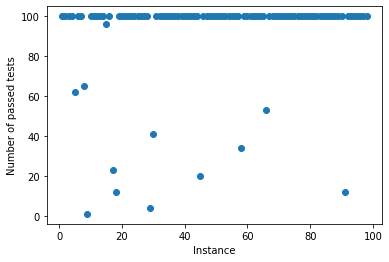

In [189]:
print(len(N_tests)/Y)
x = np.zeros(len(N_tests))
for i in range(len(N_tests)):
    x[i] = i+1
plt.scatter(x, N_tests)
plt.xlabel('Instance')
plt.ylabel('Number of passed tests')
plt.show()